# Prerequisite: always run:

In [25]:
import sys
sys.path.append('/shared_data0/weiqiuy/exlib/src')

from cosmogrid_utils import WrappedModel, show_masks_weights, show_masked_img, get_masks_used

# backbone layer - input hidden size mapping
# layer -1 has input_hidden_size of 48
bbl_ihs_mapping = {
    -1: 48,
    -2: 32,
    -3: 16
}

# Show SOP Cosmogrid

In this notebook, we describe how to load an existing sop model and show the groups.
We will break down into the following steps:

1. Load the model from a directory
2. Show the groups

In [36]:
import torch
import os
import sys
sys.path.append('/shared_data0/weiqiuy/exlib/src')
from exlib.modules.sop import SOPConfig, SOPImageCls, get_chained_attr
from exlib.datasets.mass_maps import MassMapsConvnetForImageRegression
from datasets import load_dataset

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


# init backbone model
backbone_model = MassMapsConvnetForImageRegression.from_pretrained('BrachioLab/massmaps-conv')
backbone_model = backbone_model.to(device)
processor = None

# get needed wrapped models
original_model = WrappedModel(backbone_model, output_type='logits')
wrapped_backbone_model = WrappedModel(backbone_model, output_type='tuple')
projection_layer = WrappedModel(backbone_model, output_type='hidden_states', layer=-2)

# load trained sop model
model = SOPImageCls.from_pretrained('BrachioLab/sop-massmaps-conv', 
                                    blackbox_model=wrapped_backbone_model,
                                    projection_layer=projection_layer)

model = model.to(device)
model.eval();

projection layer is not frozen


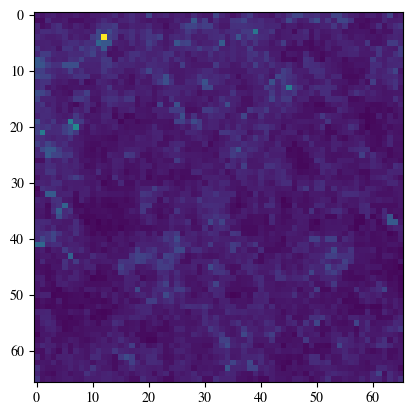

In [37]:
# Show an example of data
import matplotlib.pyplot as plt

val_dataset = load_dataset('BrachioLab/massmaps-cosmogrid-100k', split='validation')
val_dataset.set_format('torch', columns=['input', 'label'])

batch = next(iter(val_dataset))
inputs = batch['input'].to(device)[:,None]
labels = batch['label'].to(device)

plt.imshow(inputs[0][0].cpu())

In [38]:
# Get the outputs from the model
outputs = model(inputs, return_tuple=True)

In [39]:
print('logits', outputs.logits.shape)
print('logits_all', outputs.logits_all.shape)
print('masks', outputs.masks.shape)
print('group_attributions', outputs.group_attributions.shape)

logits torch.Size([1, 2])
logits_all torch.Size([1, 20, 2])
masks torch.Size([1, 20, 66, 66])
group_attributions torch.Size([1, 20, 2])


In [40]:
outputs.mask_weights[0,:,0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8945,
        0.1055, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000], device='cuda:0', grad_fn=<SelectBackward0>)

## Show the groups from SOP for this image

Here we show the groups for this image. This `show_masks_weights` function shows the groups that are actually used where `outputs.mask_weights` is nonzero, and then show all the groups.

Omega
original


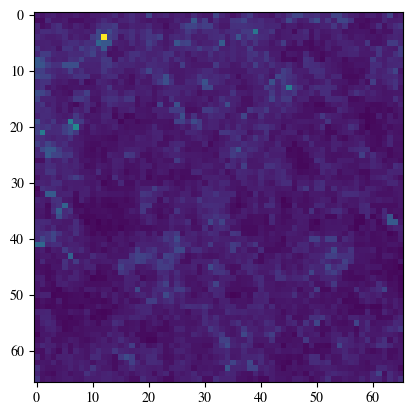

selected masks


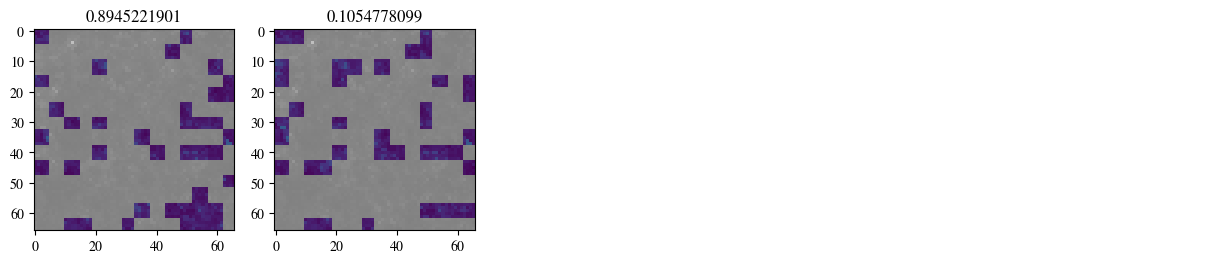

all masks


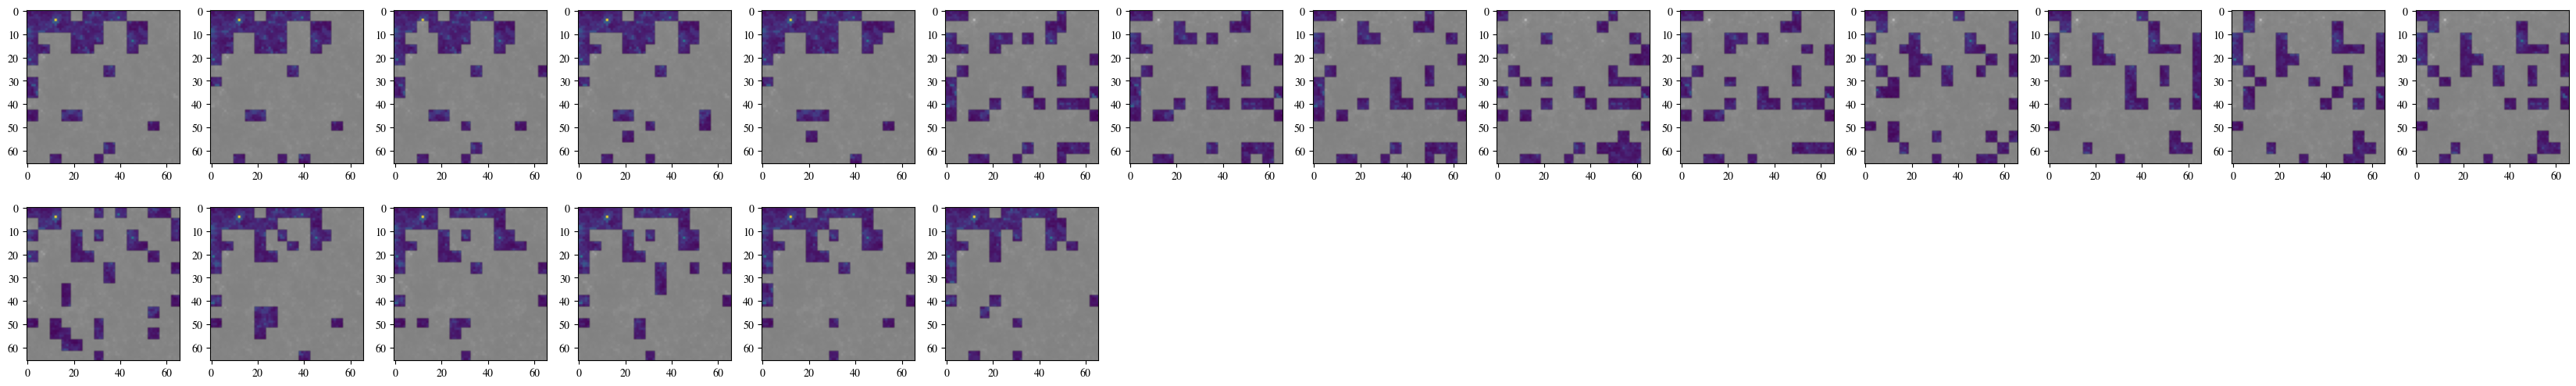

sigma
original


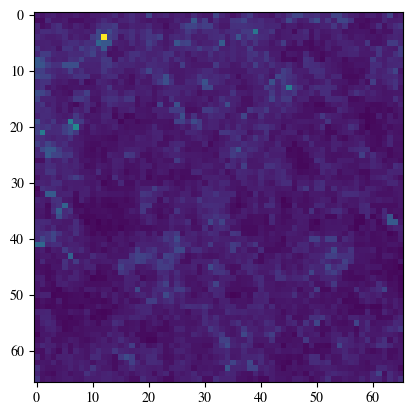

selected masks


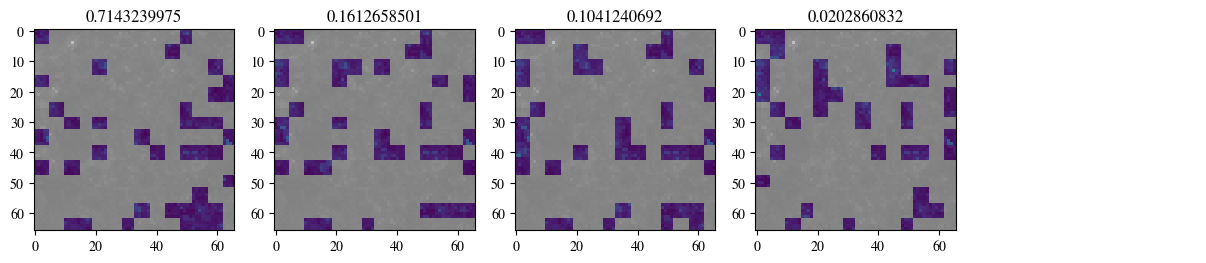

all masks


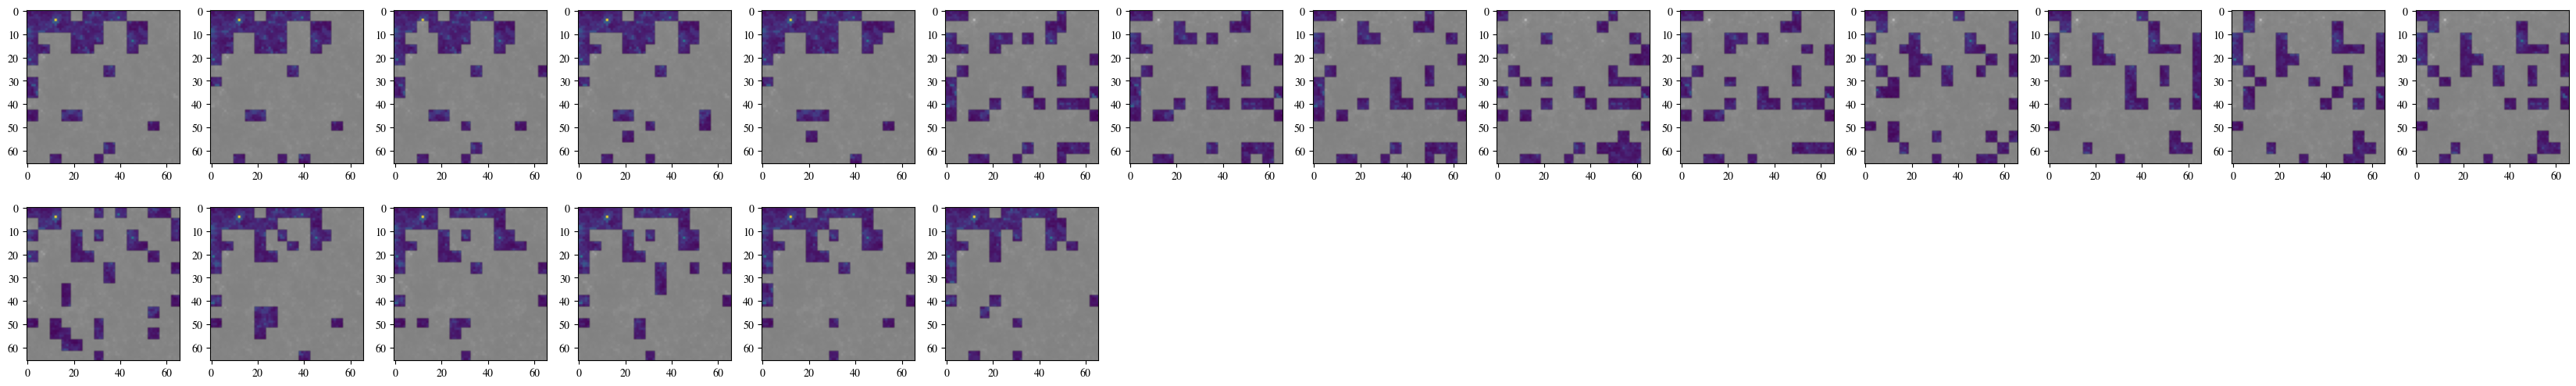

In [42]:
print('Omega')
show_masks_weights(inputs, outputs, pred=0)
print('sigma')
show_masks_weights(inputs, outputs, pred=1)

# Initialize an SOP model from scratch and train

We first show how to initialize an SOP model with a pretrained CNN model for Cosmogrid, and then show the groups from this untrained SOP, and then we show how to train it.

## Init SOP with a pretrained ViT model

In [10]:
import torch
import os
import sys
sys.path.append('/shared_data0/weiqiuy/exlib/src')
from exlib.modules.sop import SOPConfig, SOPImageCls, get_chained_attr
from exlib.datasets.mass_maps import MassMapsConvnetForImageRegression
from datasets import load_dataset


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# init backbone model
backbone_model = MassMapsConvnetForImageRegression.from_pretrained('BrachioLab/massmaps-conv')
backbone_model = backbone_model.to(device)
processor = None

layer = -2
input_hidden_size = bbl_ihs_mapping[layer]

num_heads = 4

# get needed wrapped models
original_model = WrappedModel(backbone_model, output_type='logits')
wrapped_backbone_model = WrappedModel(backbone_model, output_type='tuple')
projection_layer = WrappedModel(backbone_model, output_type='hidden_states', layer=layer)

config = SOPConfig(
    hidden_size=32,
    num_labels=2,
    input_hidden_size=input_hidden_size,
    attn_patch_size=6,
    num_heads=num_heads,
    num_masks_sample=20,
    num_masks_max=200,
    image_size=66,
    num_channels=1,
    class_weight_layer='model.fc4',
    group_gen_scale=0.06,
    group_sel_scale=10,
    group_gen_blur_ks1=1,
    group_gen_blur_sigma1=1
)


model = SOPImageCls(config, blackbox_model=wrapped_backbone_model, projection_layer=projection_layer)
model.eval();
model = model.to(device)

projection layer is not frozen


## Show the groups of an untrained SOP

We can see that the groups are kind of random.

Omega
original


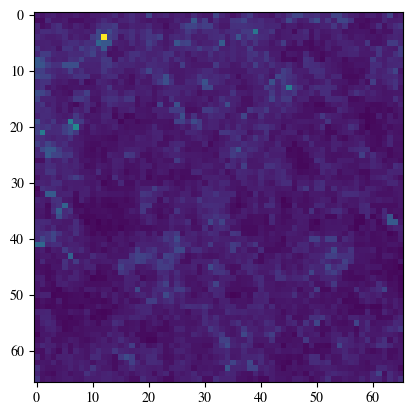

selected masks


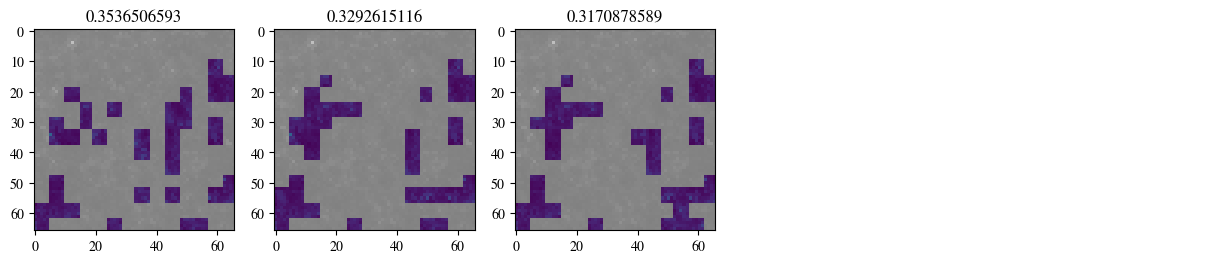

all masks


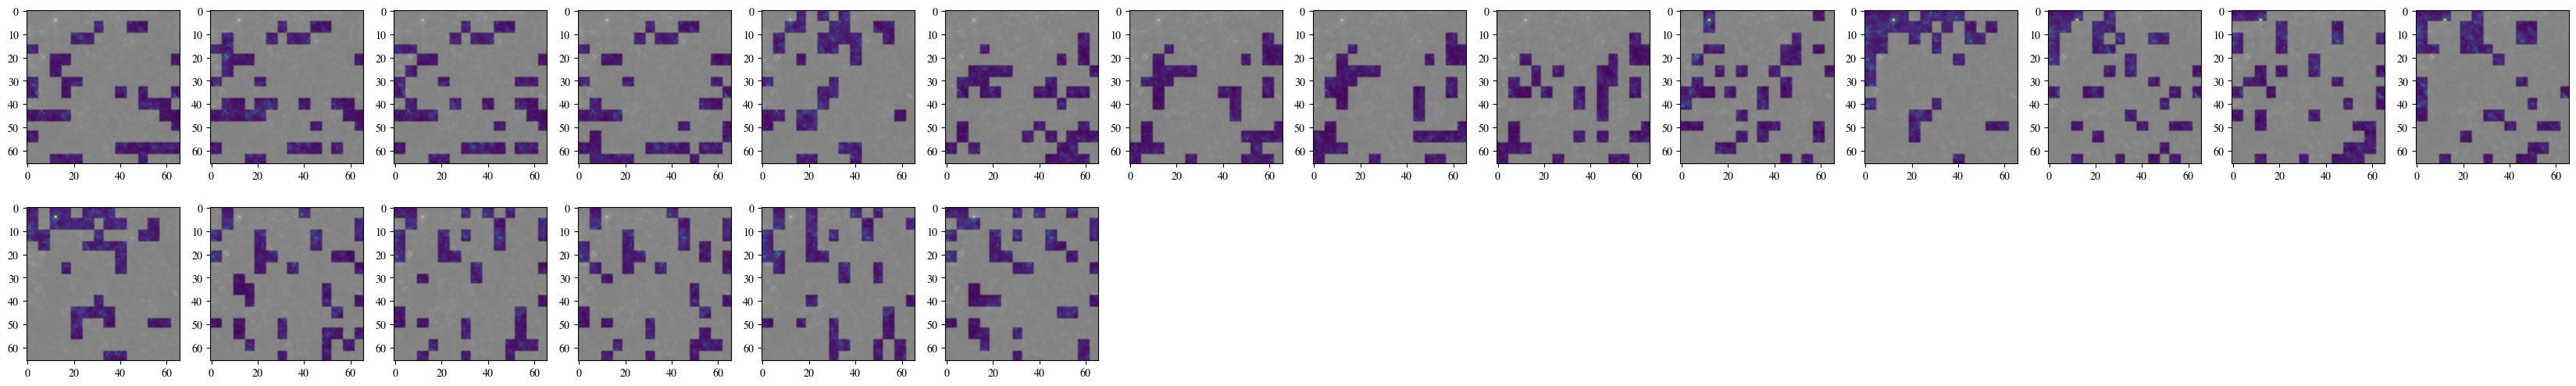

sigma
original


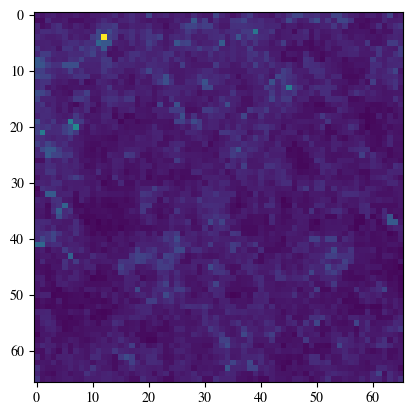

selected masks


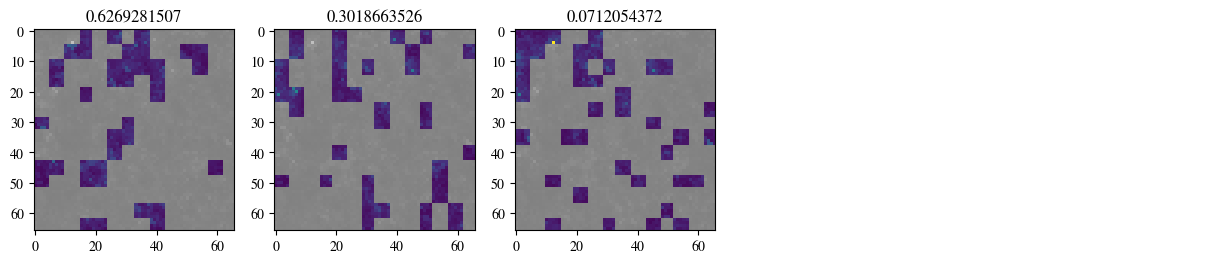

all masks


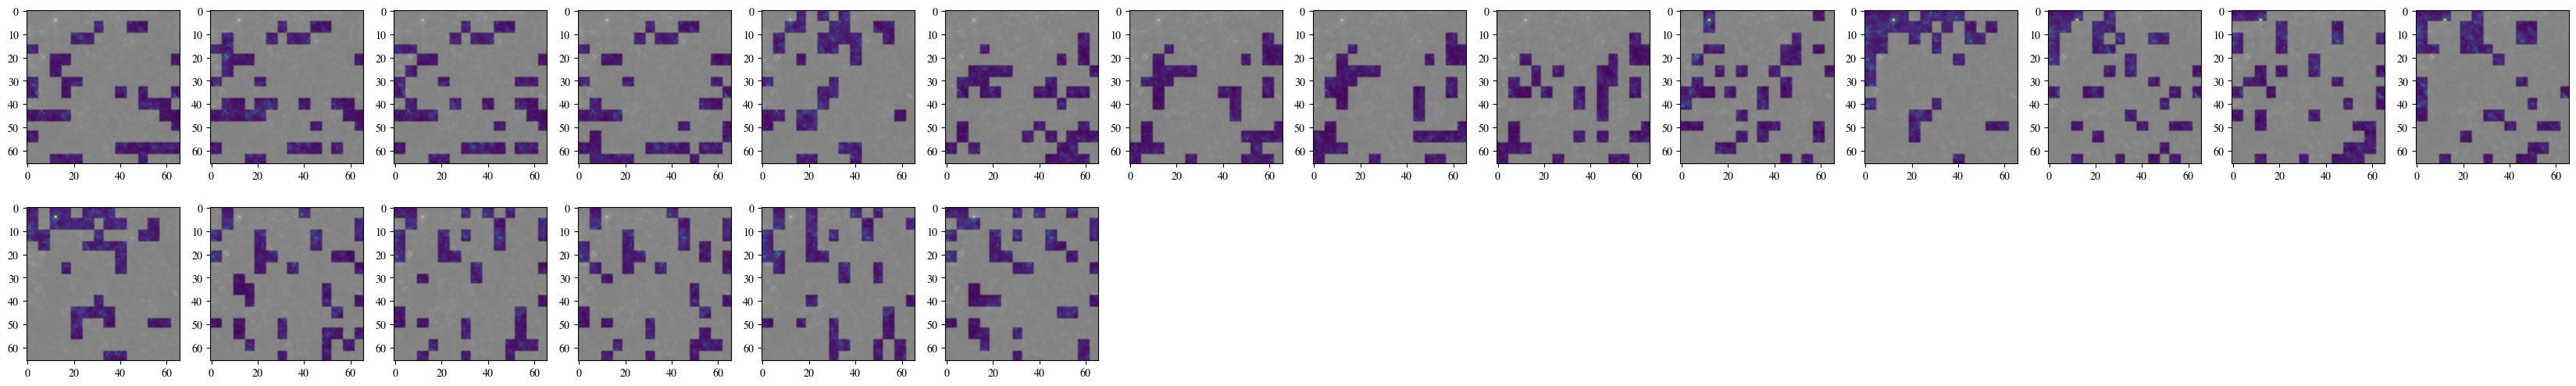

In [3]:
# Show an example of data
import matplotlib.pyplot as plt

val_dataset = load_dataset('BrachioLab/massmaps-cosmogrid-100k', split='validation')
val_dataset.set_format('torch', columns=['input', 'label'])

batch = next(iter(val_dataset))
inputs = batch['input'].to(device)[:,None]
labels = batch['label'].to(device)

# Get the outputs from the model
outputs = model(inputs, return_tuple=True)

print('Omega')
show_masks_weights(inputs, outputs, pred=0)
print('sigma')
show_masks_weights(inputs, outputs, pred=1)

## Train

Training SOP is the same as training any model. You can simply plug SOP into your original training pipeline by replaceing the original model with the SOP model.

In [38]:
import sys
sys.path.append('/shared_data0/weiqiuy/sop/src')

from torch.utils.data import Subset

# Load data
train_dataset = load_dataset('BrachioLab/massmaps-cosmogrid-100k', split='train')
val_dataset = load_dataset('BrachioLab/massmaps-cosmogrid-100k', split='validation')
test_dataset = load_dataset('BrachioLab/massmaps-cosmogrid-100k', split='test')
train_dataset.set_format('torch', columns=['input', 'label'])
val_dataset.set_format('torch', columns=['input', 'label'])
test_dataset.set_format('torch', columns=['input', 'label'])


# get a subset of train dataset for evaluating train loss
# Total size of the dataset
dataset_size = len(train_dataset)
# Generate 1000 evenly spaced indices over the entire dataset
subset_indices = torch.linspace(0, dataset_size - 1, steps=1000).long().tolist()
train_val_dataset = Subset(train_dataset, subset_indices)

In [39]:
from torch.utils.data import DataLoader

# training args
batch_size = 16
lr = 0.000005
num_epochs = 20
# warmup_steps = 2000
mask_batch_size = 64

# Create a DataLoader to batch and shuffle the data
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
train_val_dataloader = DataLoader(train_val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Simple training loop

Here is a showcase of a simple training loop. I did not include saving and evaluating for simplicity.

In [4]:
import torch.nn as nn
from torch.optim import SGD, AdamW
from tqdm.auto import tqdm

# training args
batch_size = 16
lr = 0.000005
num_epochs = 20
warmup_steps = 2000
mask_batch_size = 64

from torch.optim import SGD, AdamW

lr = 5e-6
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

In [48]:
import logging
import math
import json


# Iterate over the data
best_val_loss = math.inf
step = 0
train_log_interval = 100
val_eval_interval = 400

criterion_none = nn.MSELoss(reduction='none')

logging.basicConfig(filename=os.path.join(exp_dir, 'train.log'), level=logging.INFO)

num_epochs = 1
num_training_steps = len(train_dataloader) * num_epochs
train_rep_step_size = int(num_training_steps / config.num_heads)

progress_bar = tqdm(range(num_training_steps))
model.train()
for epoch in range(math.ceil(num_epochs)):
    running_loss = 0.0
    running_loss_scaled = 0.0
    running_total = 0
    for i, batch in enumerate(train_dataloader):
        inputs = batch['input']
        labels = batch['label']
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

        bsz = inputs.shape[0]
        
        # if you have superpixels, you will want them here
        segs = None
            
        optimizer.zero_grad()
        train_rep_step = step // train_rep_step_size
        outputs = model(inputs, segs, epoch=train_rep_step, mask_batch_size=mask_batch_size, 
                       return_tuple=True, separate_scale=True) # separate_scale = True for regression tasks
        logits = outputs.logits
        loss_all = criterion_none(logits, labels)
        loss = loss_all.mean()
        
        loss_scaled = ((outputs.mask_weights * (outputs.logits - labels)[:,None] * (- outputs.loss_scale[:,:,None])).sum(1) ** 2).mean()
        loss_scaled.backward()
        optimizer.step()
        
        running_loss += loss.item() * labels.size(0)
        running_loss_scaled += loss_scaled.item() * labels.size(0)
        running_total += labels.size(0)
        
        if i % train_log_interval == train_log_interval - 1 or i == len(train_dataloader) - 1:
            # Print training loss every 100 batches
            curr_lr = float(optimizer.param_groups[0]['lr'])
            log_message = f'Epoch {epoch}, Batch {i + 1}, Loss {running_loss / running_total:.4f}, LR {curr_lr:.8f}'
            print(log_message)
            logging.info(log_message)
            running_loss = 0.0
            running_total = 0
        
            
        # lr_scheduler.step()
        progress_bar.update(1)
        
        step += 1
        if step > num_training_steps:
            break
    if step > num_training_steps:
        break    

  0%|          | 0/5625 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [49]:
# You can then save the model like how you can save any huggingface model
model.save_pretrained('../../exps/cosmogrid_exp')

### Complete Training Loop.

Here is the complete version of the training loop I use.
1. Evaluation code
2. Evaluate before training
3. Train with evaluation and checkpoints

In [22]:
# from exlib.modules.sop import show_masks_weights, get_masks_used

def evaluate(model, dataloader, criterion, sop=True, binary_threshold=-1, verbose=0, eval_all=False):
    print('Eval ...')
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    total_nnz = 0
    total_num_masks = 0
    total_coverage = 0
    total_nnz_all = 0
    correct_max = 0
    correct_max_omega = 0
    correct_max_sigma = 0
    correct_num = 0
    total_nnz_omega = 0
    total_nnz_sigma = 0
    total_num_masks_omega = 0
    total_num_masks_sigma = 0
    loss_all = []
    
    criterion_none = nn.MSELoss(reduction='none')

    with torch.no_grad():
        progress_bar_eval = tqdm(range(len(dataloader)))
        for bi, batch in enumerate(dataloader):
            if not eval_all:
                if bi % 10 != 0:
                    progress_bar_eval.update(1)
                    continue
            # Now you can use `inputs` and `labels` in your training loop.
            # inputs, labels, masks, _ = batch
            inputs = batch['input']
            labels = batch['label']
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            # masks = masks.to(device)
            bsz = inputs.shape[0]
            
            # if you use superpixel, you should pass it here
            segs = None

            if sop:
                outputs = model(inputs, segs, return_tuple=True, binary_threshold=binary_threshold,
                               separate_scale=True)

                if verbose > 0:
                    if bi in [10, 20, 30]:
                        show_masks_weights(inputs, outputs)

                logits = outputs.logits

                for i in range(len(logits)):
                    for pred in range(2):

                        outputs_processed = get_masks_used(outputs, i=i, pred=pred)
                        masks = outputs_processed['masks_sort_used']
                        mask_weights = outputs_processed['mask_weights_sort_used']

                        # pred_mask_idxs_sort = outputs.mask_weights[i,:,pred].argsort(descending=True)
                        nnz = (masks[mask_weights != 0] > 0).sum() / masks[mask_weights != 0].view(-1).shape[0]
                        
                        if pred == 0:
                            total_nnz_omega += nnz.item()
                            total_num_masks_omega += len(masks)
                        else:
                            total_nnz_sigma += nnz.item()
                            total_num_masks_sigma += len(masks)
                        
                        coverage = masks.bool().sum(-3).bool().sum() / (masks.shape[-1] * masks.shape[-2])
                        total_coverage += coverage.item()
                    
                    nnz_all = (outputs.masks != 0).sum() / outputs.masks.view(-1).shape[0]
                    total_nnz_all += nnz_all.item()
                    
                # import pdb; pdb.set_trace()
                # preds_max = outputs.logits_all.argmax(-1) # (bsz, num_masks)
                # print('outputs.logits_all', outputs.logits_all.shape)
                # print('labels', labels.shape)
                loss_max = criterion_none(outputs.logits_all, 
                                     labels[:,None].expand(outputs.logits_all.shape)).min(1).values # check
                
                correct_max += loss_max.mean().item() * bsz #(preds_max == labels[:,None]).sum(-1).bool().sum().item()
                correct_max_omega += loss_max.sum(0)[0].item()
                correct_max_sigma += loss_max.sum(0)[1].item()
                correct_num += (loss_max < 0.01).sum().item()  #(preds_max == labels[:,None]).sum(-1).sum().item()
            else:
                outputs = model(inputs)
                if isinstance(outputs, torch.Tensor):
                    logits = outputs
                else:
                    logits = outputs.logits
                
                loss_max = criterion_none(logits, labels) # check
                
                # correct_max += loss_max.sum().item() #(preds_max == labels[:,None]).sum(-1).bool().sum().item()
                correct_max_omega += loss_max.sum(0)[0].item()
                correct_max_sigma += loss_max.sum(0)[1].item()
            
            # val loss
            loss = criterion(logits, labels) * bsz
            # import pdb; pdb.set_trace()
            loss_all.extend(criterion_none(logits, labels).mean(-1).cpu().numpy().tolist())
            total_loss += loss.item()
            
            # acc
            # _, predicted = torch.max(logits.data, 1)
            # correct += (predicted == labels).sum().item()
            # print('predicted', predicted, 'labels', labels)
            
            total += labels.size(0)
            
            progress_bar_eval.update(1)
            # if bi > 100:
            #     break
    
    val_acc = correct / total
    val_loss = total_loss / total
    val_nnz = total_nnz / total
    val_nnz_all = total_nnz_all / total
    val_n_masks_avg = total_num_masks / total
    val_coverage = total_coverage / total
    val_min_loss = correct_max / total
    val_min_loss_omega = correct_max_omega / total
    val_min_loss_sigma = correct_max_sigma / total
    val_perc_correct = correct_num / total
    val_n_masks_avg_omega = total_num_masks_omega / total
    val_n_masks_avg_sigma = total_num_masks_sigma / total
    
    model.train()
    
    return {
        'val_acc': val_acc,
        'val_loss': val_loss,
        'val_nnz': val_nnz,
        'val_nnz_all': val_nnz_all,
        'val_n_masks_avg': val_n_masks_avg,
        'val_coverage': val_coverage,
        'total': total,
        'val_min_loss': val_min_loss,
        'val_perc_correct': val_perc_correct,
        'val_n_masks_avg_omega': val_n_masks_avg_omega,
        'val_n_masks_avg_sigma': val_n_masks_avg_sigma,
        'val_min_loss_omega': val_min_loss_omega,
        'val_min_loss_sigma': val_min_loss_sigma,
        'loss_all': loss_all
    }

In [21]:
import torch.nn as nn
from torch.optim import SGD, AdamW
from tqdm.auto import tqdm

# training args
batch_size = 16
lr = 0.000005
num_epochs = 20
warmup_steps = 2000
mask_batch_size = 64

lr = 5e-6
criterion = nn.MSELoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

backbone_val_results = evaluate(original_model, val_dataloader, criterion, sop=False)
backbone_val_loss = backbone_val_results['val_loss']
print('Backbone val loss: ', backbone_val_loss)

Eval ...


  0%|          | 0/625 [00:00<?, ?it/s]

Backbone val loss:  0.007877281608266963


In [27]:
val_results = evaluate(model, val_dataloader, criterion, sop=True)
val_loss = val_results['val_loss']
print('Untrained sop val loss: ', val_loss)

Eval ...


  0%|          | 0/625 [00:00<?, ?it/s]

Untrained sop val loss:  0.043325199464720396


In [41]:
val_results = evaluate(model, train_val_dataloader, criterion, sop=True)
val_loss = val_results['val_loss']
print('Untrained sop train loss: ', val_loss)

Eval ...


  0%|          | 0/63 [00:00<?, ?it/s]

Untrained sop train loss:  0.041620684787631035


In [29]:
val_results = evaluate(model, test_dataloader, criterion, sop=True)
val_loss = val_results['val_loss']
print('Untrained sop test loss: ', val_loss)
# should report test loss in the end, but validate with only val loss

Eval ...


  0%|          | 0/625 [00:00<?, ?it/s]

Untrained sop test loss:  0.043325199464720396


  0%|          | 0/5625 [00:00<?, ?it/s]

Eval ...


  0%|          | 0/625 [00:00<?, ?it/s]

original


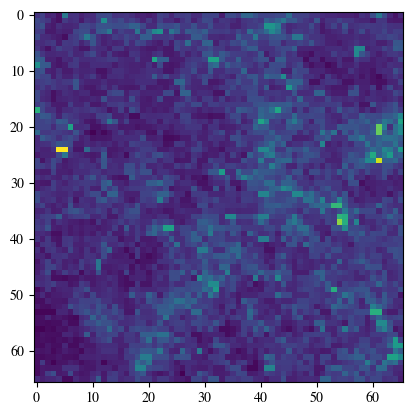

selected masks


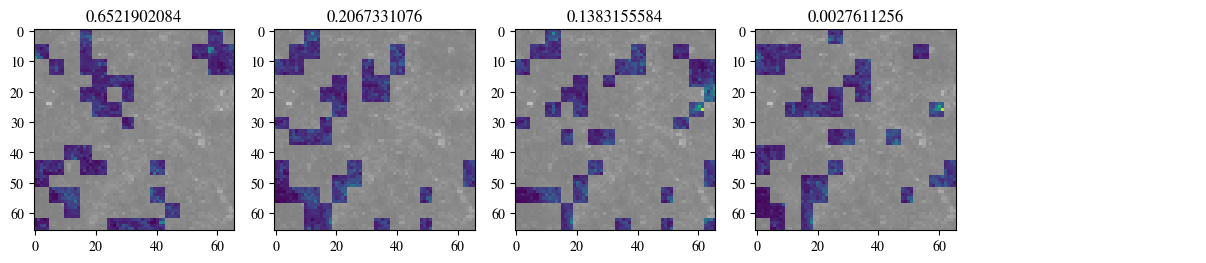

all masks


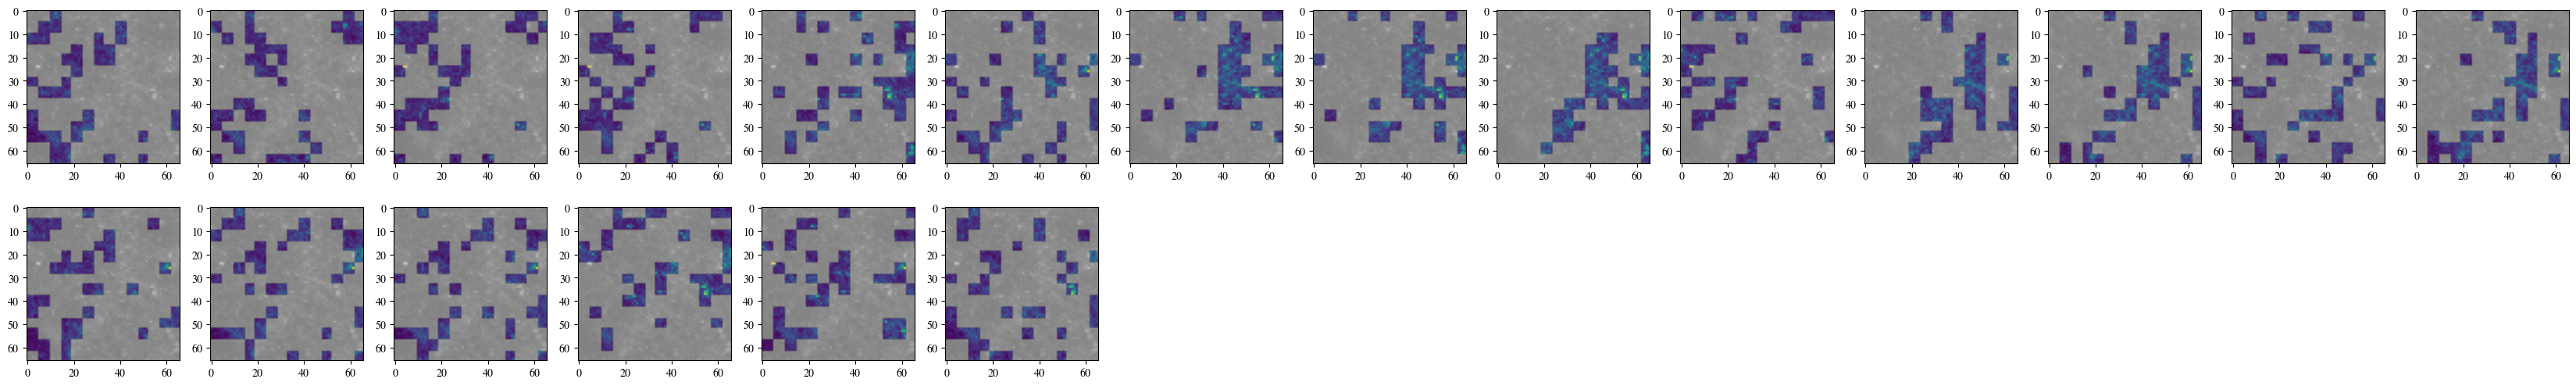

original


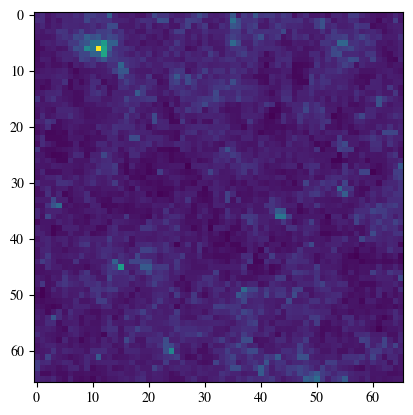

selected masks


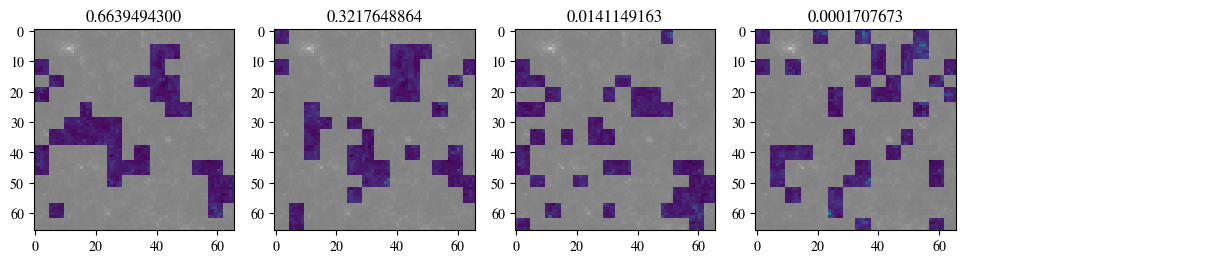

all masks


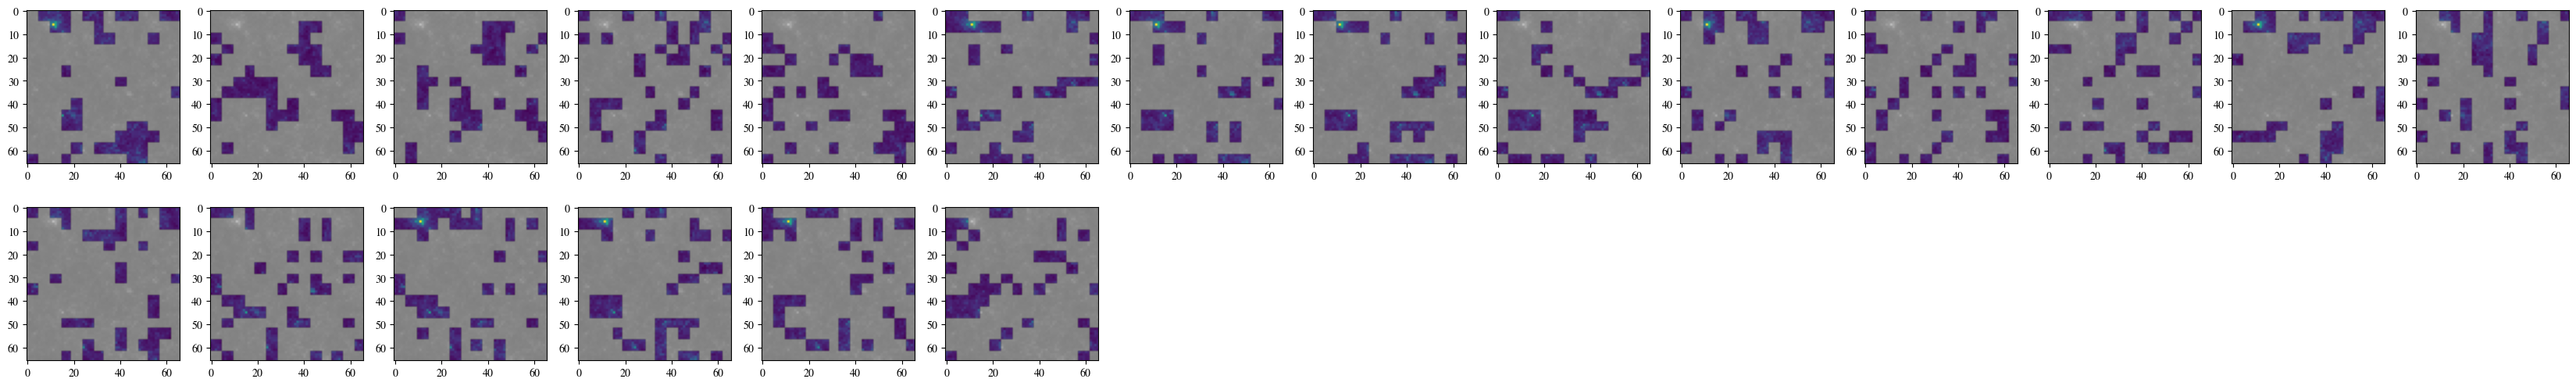

original


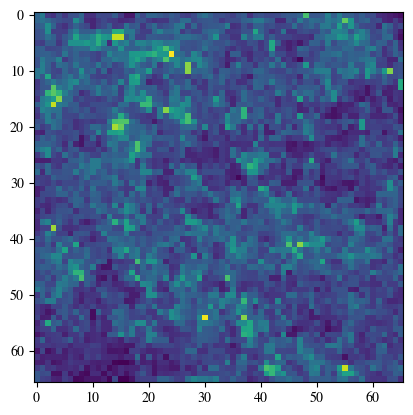

selected masks


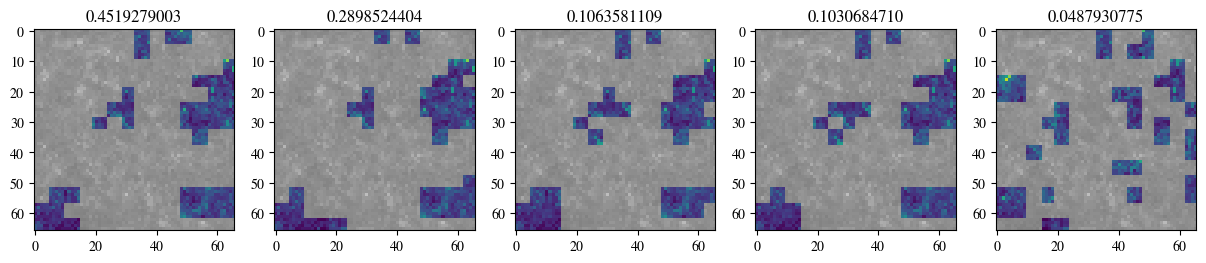

all masks


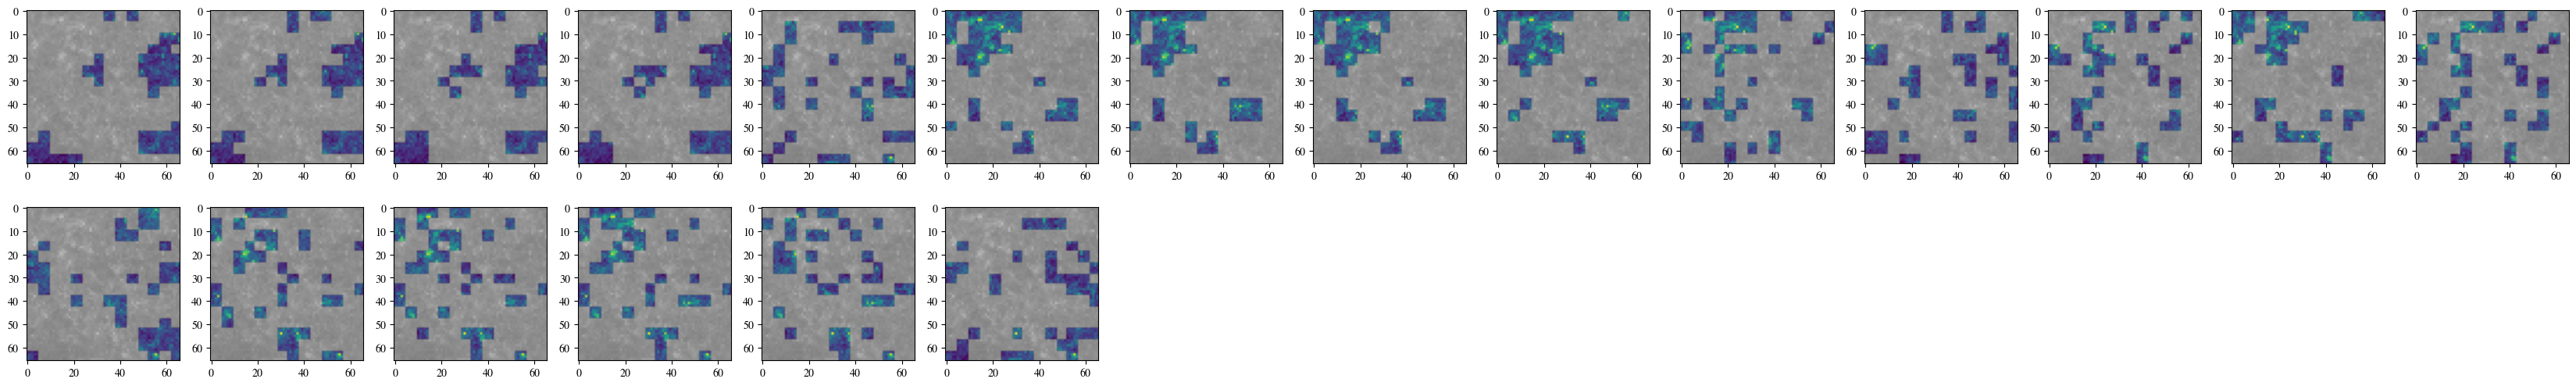

Eval ...


  0%|          | 0/63 [00:00<?, ?it/s]

original


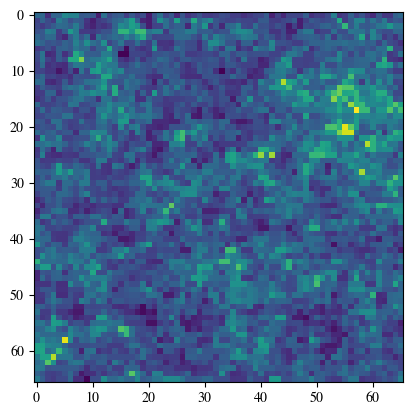

selected masks


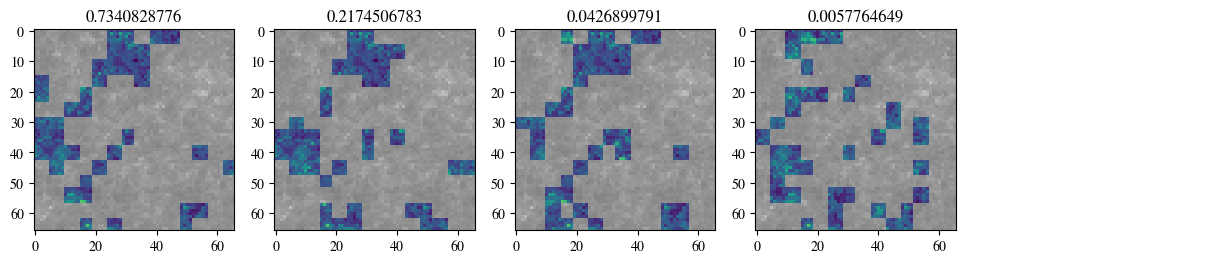

all masks


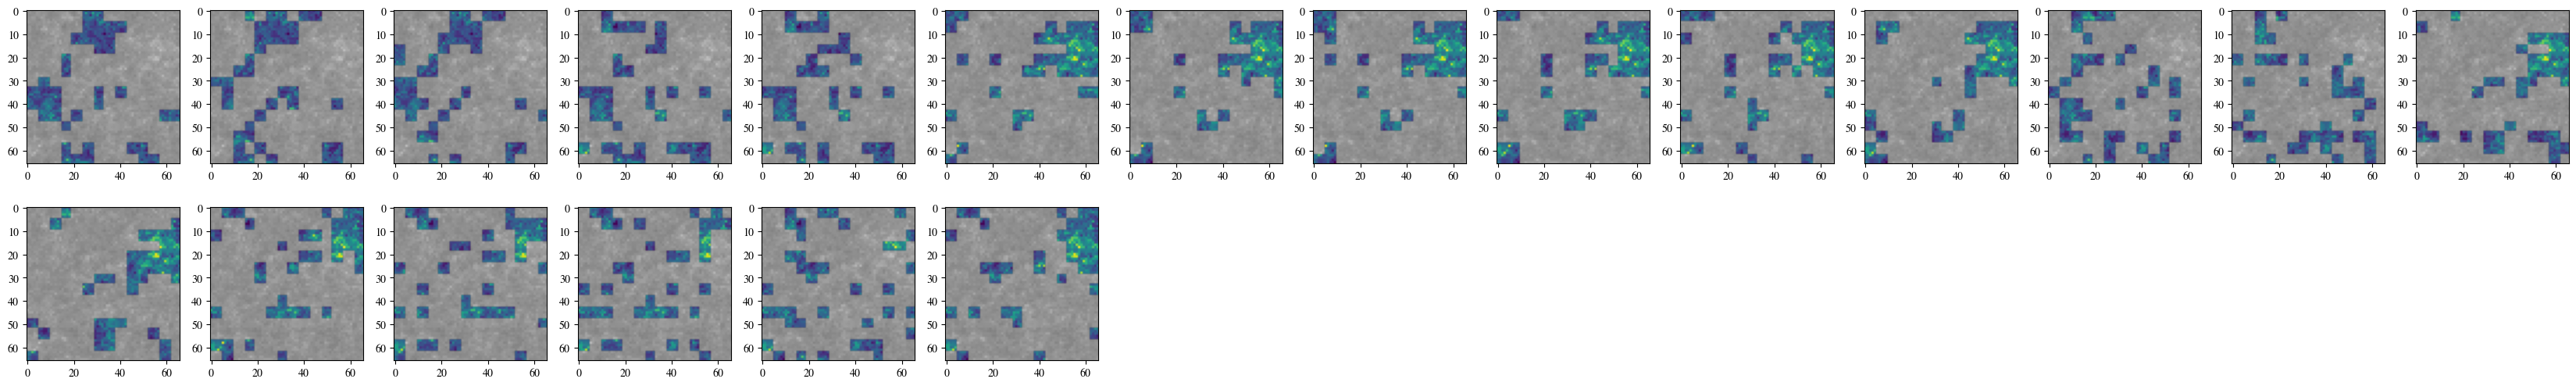

original


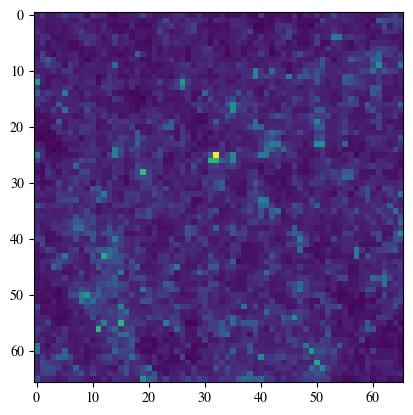

selected masks


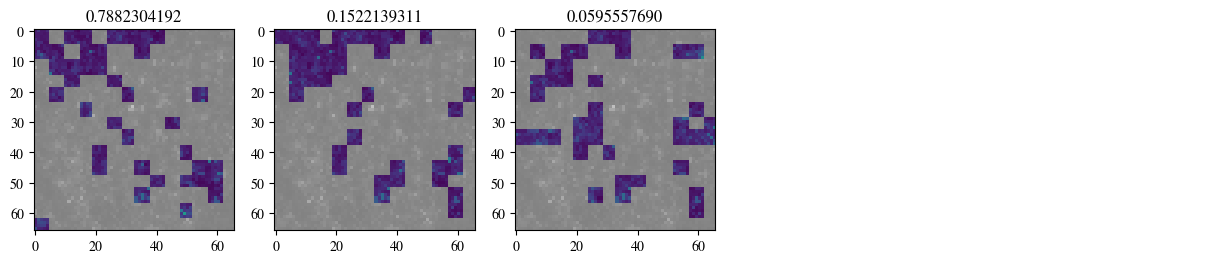

all masks


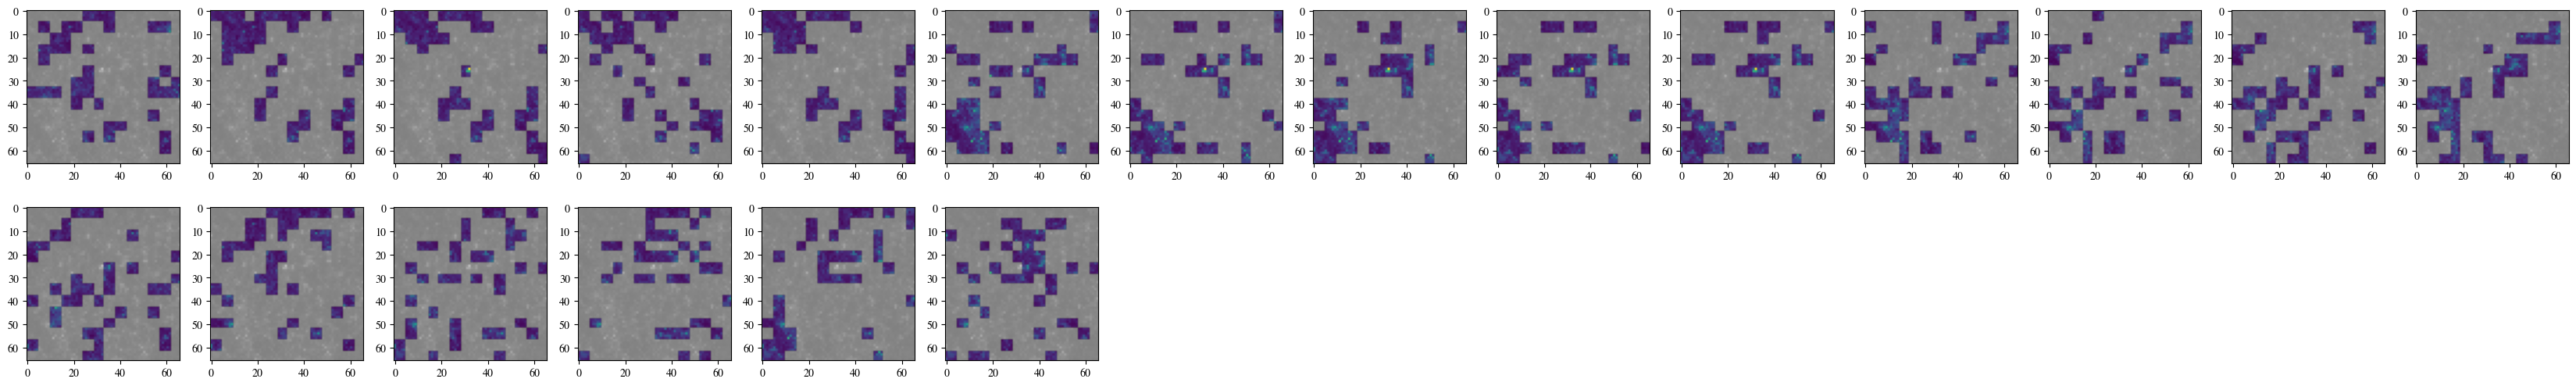

original


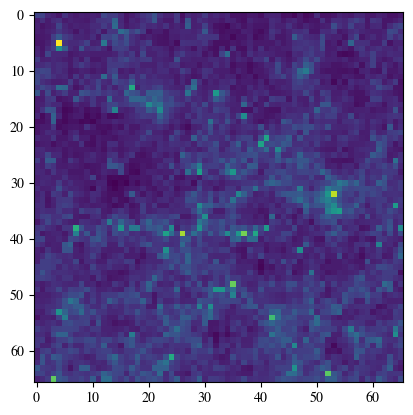

selected masks


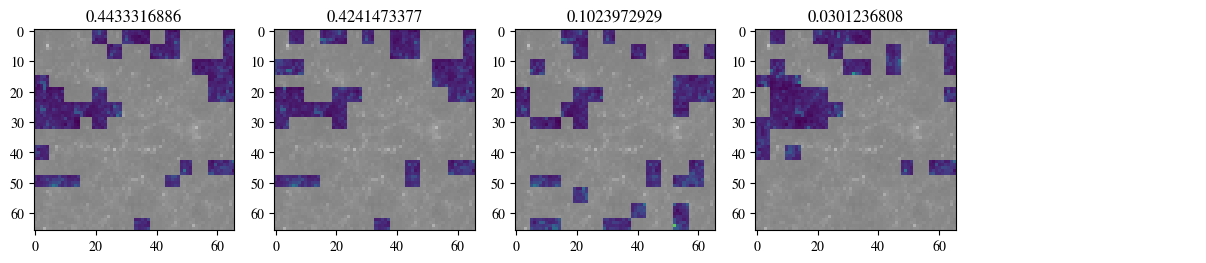

all masks


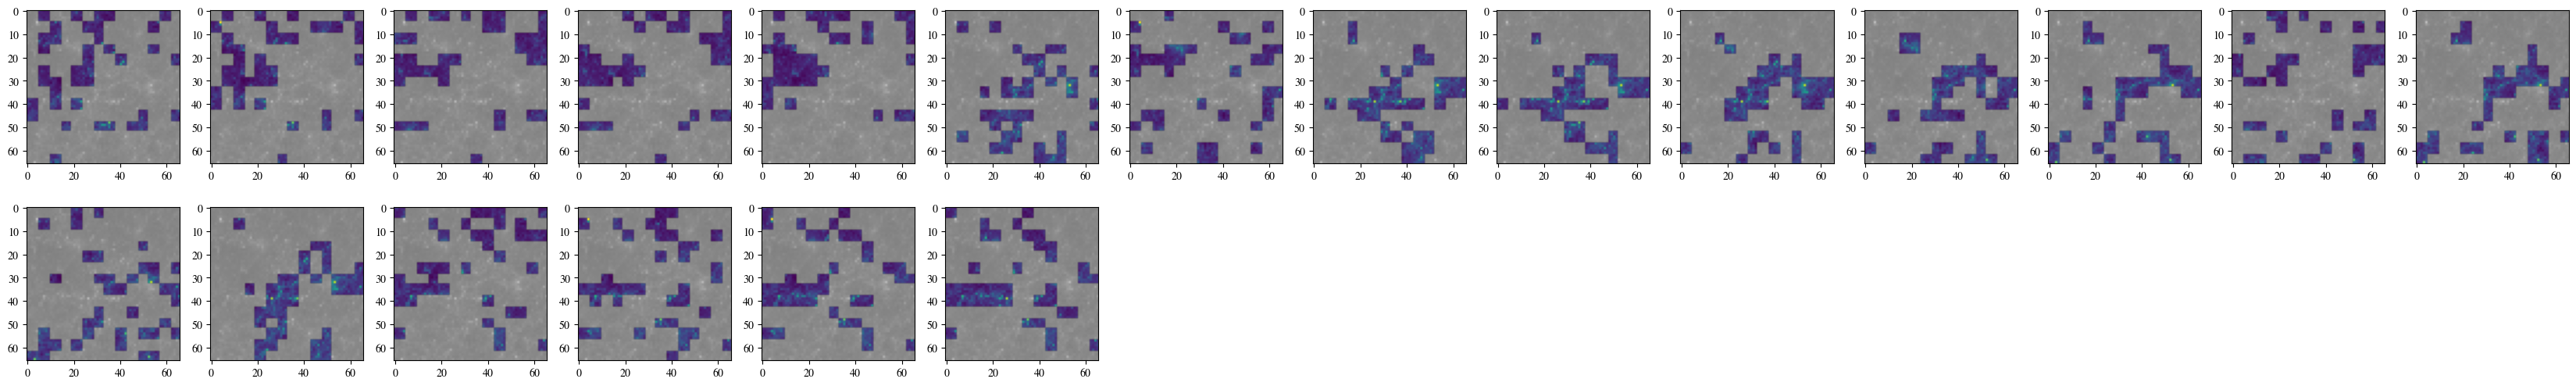

Epoch 0, Step 0, Val loss 0.0433
new best val loss: 0.04330883881757184
Best checkpoint saved at ../../exps/cosmogrid_exp/best/checkpoint.pth
Last checkpoint saved at ../../exps/cosmogrid_exp/last/checkpoint.pth
Epoch 0, Batch 100, Loss 0.0299, LR 0.00000500
Eval ...


  0%|          | 0/625 [00:00<?, ?it/s]

original


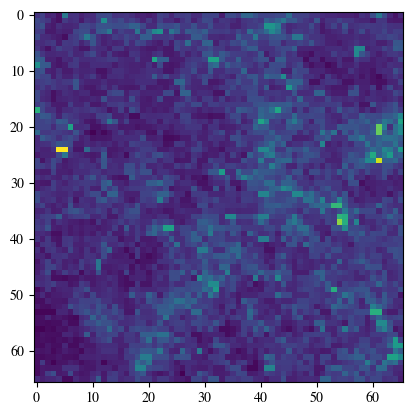

selected masks


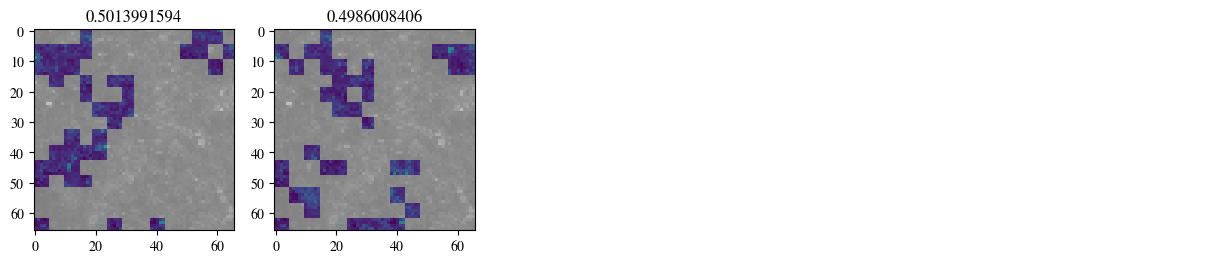

all masks


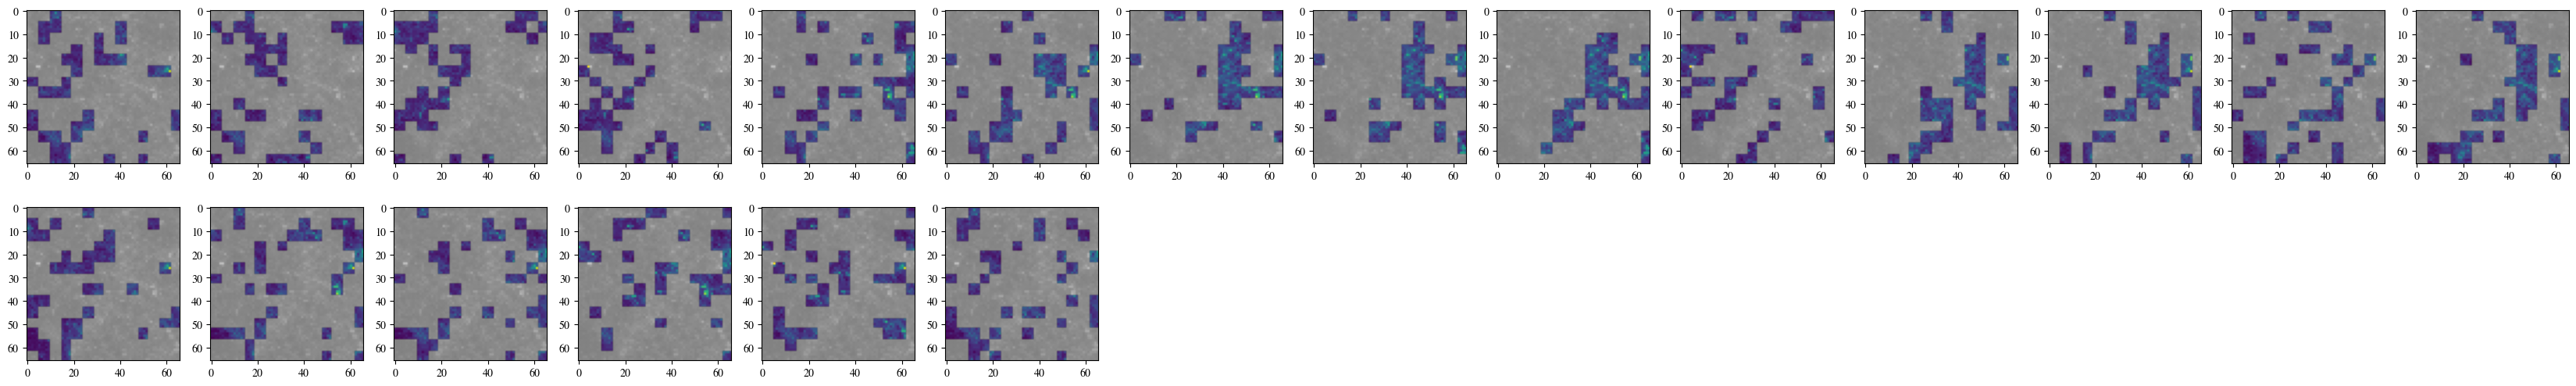

original


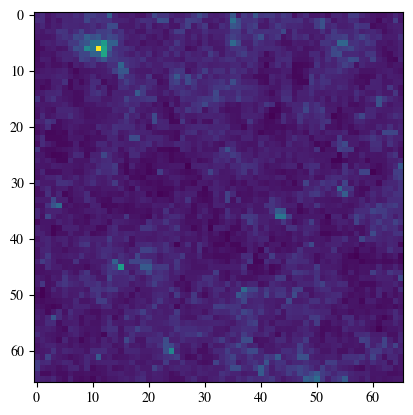

selected masks


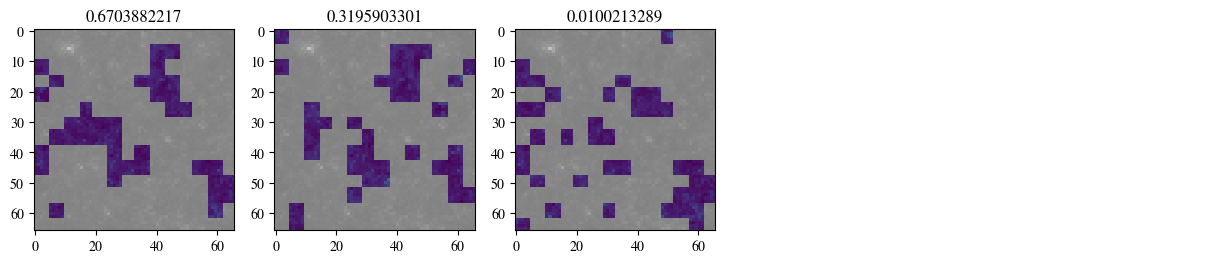

all masks


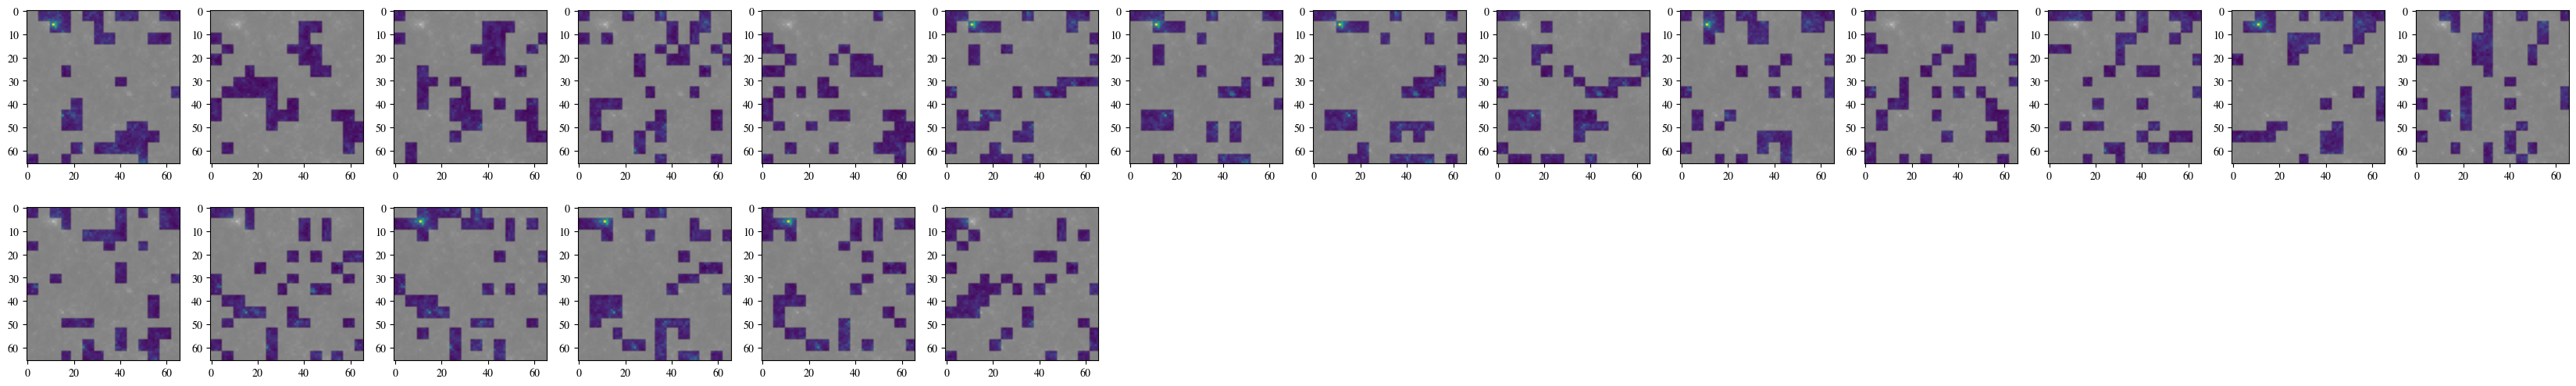

original


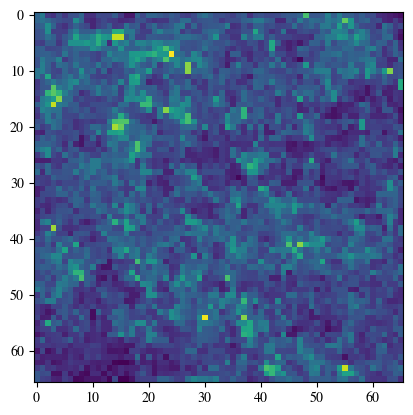

selected masks


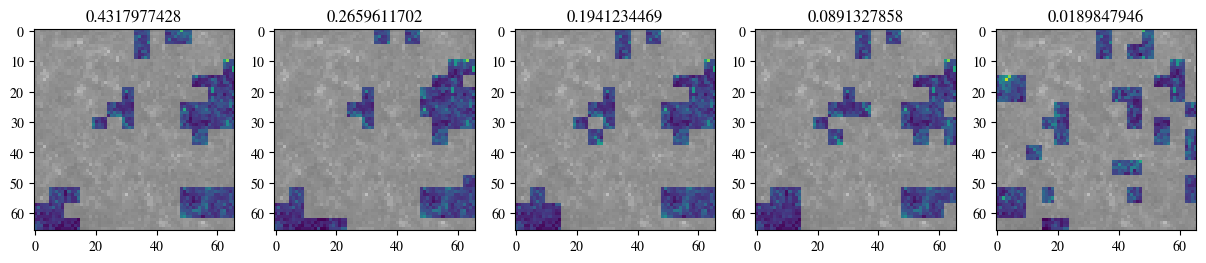

all masks


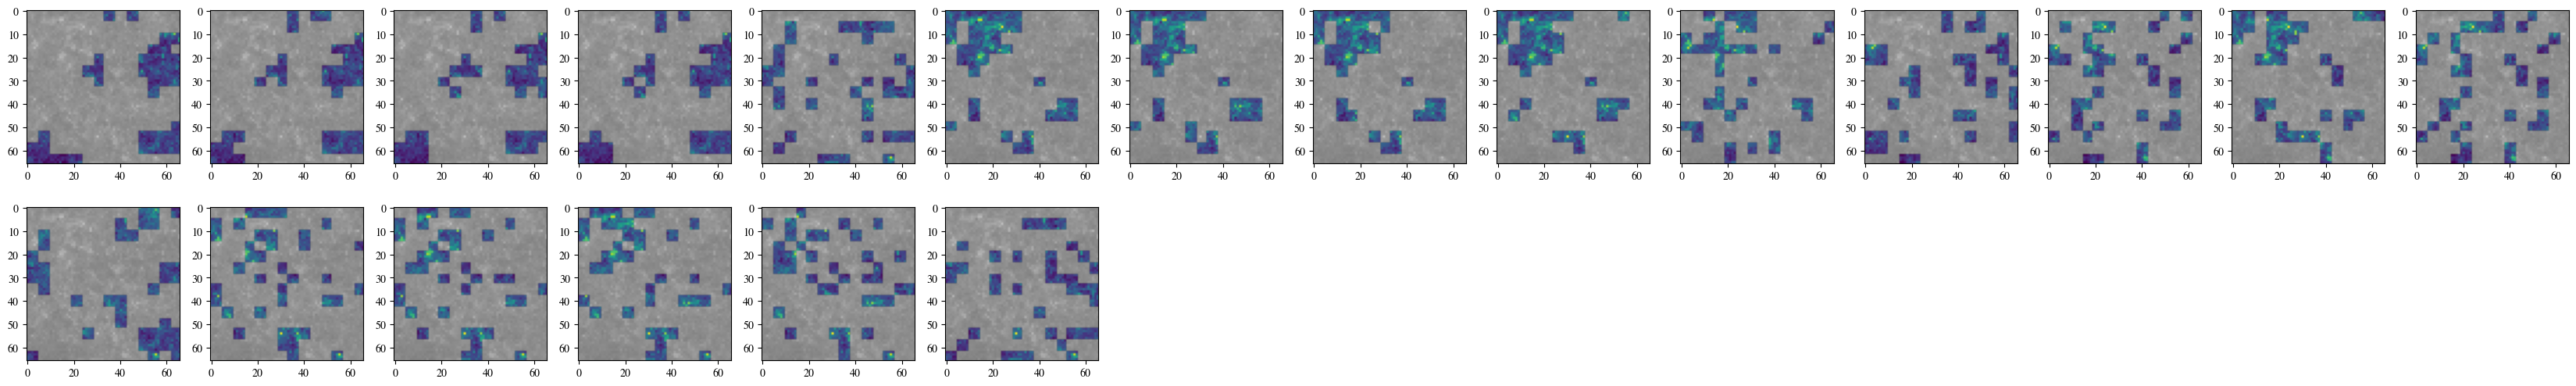

KeyboardInterrupt: 

In [47]:
import logging
import math
import json

# track = True
track = False

exp_dir = f'../../exps/cosmogrid_exp'
os.makedirs(exp_dir, exist_ok=True)

# checkpoint dirs
last_dir = os.path.join(exp_dir, 'last')
best_dir = os.path.join(exp_dir, 'best')
best_checkpoint_path = os.path.join(best_dir, 'checkpoint.pth')
last_checkpoint_path = os.path.join(last_dir, 'checkpoint.pth')
config_best_checkpoint_path = os.path.join(best_dir, 'config.json')
config_last_checkpoint_path = os.path.join(last_dir, 'config.json')
result_best_checkpoint_path = os.path.join(best_dir, 'result.json')
result_last_checkpoint_path = os.path.join(last_dir, 'result.json')
hf_best_path = os.path.join(best_dir, 'hf_model')
hf_last_path = os.path.join(last_dir, 'hf_model')

if track:
    import wandb
    wandb.init(project='sop')
    wandb.run.name = os.path.basename(exp_dir)
    wandb.log({'backbone_val_loss': backbone_val_loss,
              'val_loss': val_loss,
              'train_val_loss': train_val_loss,
              'step': 0})

# Iterate over the data
best_val_loss = math.inf
step = 0
train_log_interval = 100
val_eval_interval = 400

criterion_none = nn.MSELoss(reduction='none')

logging.basicConfig(filename=os.path.join(exp_dir, 'train.log'), level=logging.INFO)

num_epochs = 1
num_training_steps = len(train_dataloader) * num_epochs
train_rep_step_size = int(num_training_steps / config.num_heads)

progress_bar = tqdm(range(num_training_steps))
model.train()
for epoch in range(math.ceil(num_epochs)):
    running_loss = 0.0
    running_loss_scaled = 0.0
    running_total = 0
    for i, batch in enumerate(train_dataloader):
        inputs = batch['input']
        labels = batch['label']
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

        bsz = inputs.shape[0]
        
        # if you have superpixels, you will want them here
        segs = None
            
        optimizer.zero_grad()
        train_rep_step = step // train_rep_step_size
        outputs = model(inputs, segs, epoch=train_rep_step, mask_batch_size=mask_batch_size, 
                       return_tuple=True, separate_scale=True) # separate_scale = True for regression tasks
        logits = outputs.logits
        # loss = criterion(logits, labels)
        loss_all = criterion_none(logits, labels)
        loss = loss_all.mean()
        # print(loss.shape)
        # print('outputs.loss_scale', outputs.loss_scale.shape)
        # print('outputs.mask_weights', outputs.mask_weights.shape)
        # import pdb; pdb.set_trace()
        
        loss_scaled = ((outputs.mask_weights * (outputs.logits - labels)[:,None] * (- outputs.loss_scale[:,:,None])).sum(1) ** 2).mean()
        # loss_scaled = loss_all.mean() - (outputs.loss_scale[:,:,None] * outputs.mask_weights).sum(1).mean() / 20
        loss_scaled.backward()
        optimizer.step()
        
        running_loss += loss.item() * labels.size(0)
        running_loss_scaled += loss_scaled.item() * labels.size(0)
        running_total += labels.size(0)
        
        if i % train_log_interval == train_log_interval - 1 or i == len(train_dataloader) - 1:
            # Print training loss every 100 batches
            curr_lr = float(optimizer.param_groups[0]['lr'])
            log_message = f'Epoch {epoch}, Batch {i + 1}, Loss {running_loss / running_total:.4f}, LR {curr_lr:.8f}'
            print(log_message)
            logging.info(log_message)
            if track:
                wandb.log({'train_loss': running_loss / running_total,
                           'train_loss_scaled': running_loss_scaled / running_total,
                        'lr': curr_lr,
                        'epoch': epoch,
                        'step': step})
            running_loss = 0.0
            running_total = 0
            
        # if i % val_eval_interval == val_eval_interval - 1 or i == len(train_dataloader) - 1:
        if step == 0 or i % val_eval_interval == min(100, val_eval_interval - 1) or i == len(train_dataloader) - 1:
            if (i // val_eval_interval) % 10 == 0:
                verbose = 1
            else:
                verbose = 0
            val_results = evaluate(model, val_dataloader, criterion, verbose=verbose)
            train_val_results = evaluate(model, train_val_dataloader, criterion, binary_threshold=0.5, verbose=verbose)
            # {'val_acc': 0.0, 'val_loss': 0.03201764875224659, 'val_nnz': 0.0, 
            #  'val_nnz_all': 0.1989928718124117, 'val_n_masks_avg': 0.0, 
            #  'val_coverage': 0.7050455796665379, 'total': 112, 
            #  'val_min_loss': 0.0010318758182360657, 'val_perc_correct': 1.2410714285714286, 
            #  'val_n_masks_avg_omega': 8.25, 'val_n_masks_avg_sigma': 3.8839285714285716, 
            #  'val_min_loss_omega': 0.01620863424614072, 'val_min_loss_sigma': 0.016811391272182976}
            # val_acc = val_results['val_acc']
            val_loss = val_results['val_loss']
            val_nnz = val_results['val_nnz']
            val_nnz_all = val_results['val_nnz_all']
            val_n_masks_avg_omega = val_results['val_n_masks_avg_omega']
            val_n_masks_avg_sigma = val_results['val_n_masks_avg_sigma']
            val_perc_correct = val_results['val_perc_correct']
            val_coverage = val_results['val_coverage']
            val_min_loss_omega = val_results['val_min_loss_omega']
            val_min_loss_sigma = val_results['val_min_loss_sigma']
            val_min_loss = val_results['val_min_loss']
            train_val_loss = train_val_results['val_loss']
            train_val_nnz = train_val_results['val_nnz']
            train_val_nnz_all = train_val_results['val_nnz_all']
            train_val_n_masks_avg_omega = train_val_results['val_n_masks_avg_omega']
            train_val_n_masks_avg_sigma = train_val_results['val_n_masks_avg_sigma']
            train_val_perc_correct = train_val_results['val_perc_correct']
            train_val_coverage = train_val_results['val_coverage']
            train_val_min_loss_omega = train_val_results['val_min_loss_omega']
            train_val_min_loss_sigma = train_val_results['val_min_loss_sigma']
            train_val_min_loss = train_val_results['val_min_loss']
            log_message = f'Epoch {epoch}, Step {step}, Val loss {val_loss:.4f}'
            print(log_message)
            logging.info(log_message)
            result = {
                # 'val_acc': val_acc,
                           'val_loss': val_loss,
                            'val_nnz': val_nnz,
                            'val_nnz_all': val_nnz_all,
                            'val_n_masks_avg_omega': val_n_masks_avg_omega,
                            'val_n_masks_avg_omega': val_n_masks_avg_omega,
                           # 'val_max_acc': val_max_acc,
                           'val_perc_correct': val_perc_correct,
                           'val_coverage': val_coverage,
                            'val_min_loss_omega': val_min_loss_omega,
                            'val_min_loss_sigma': val_min_loss_sigma,
                            'val_min_loss': val_min_loss,
                           # 'train_val_acc': train_val_acc,
                           'train_val_loss': train_val_loss,
                            'train_val_nnz': train_val_nnz,
                            'train_val_nnz_all': train_val_nnz_all,
                            'train_val_n_masks_avg_omega': train_val_n_masks_avg_omega,
                            'train_val_n_masks_avg_omega': train_val_n_masks_avg_omega,
                           # 'train_val_max_acc': train_val_max_acc,
                           'train_val_perc_correct': train_val_perc_correct,
                           'train_val_coverage': train_val_coverage,
                            'train_val_min_loss_omega': train_val_min_loss_omega,
                            'train_val_min_loss_sigma': train_val_min_loss_sigma,
                            'train_val_min_loss': train_val_min_loss,
                            'group_gen_scale': model.group_gen_scale,
                            'group_sel_scale': model.group_sel_scale,
                            'epoch': epoch,
                            'step': step
            }
            if track:
                wandb.log(result)
            
            
            checkpoint = {
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    # 'lr_scheduler': lr_scheduler.state_dict(),
                    'epoch': epoch,
                    'step': step,
                    'val_loss': val_loss,
                    # 'val_acc': val_acc,
                }
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                print('new best val loss:', best_val_loss)
                os.makedirs(best_dir, exist_ok=True)
                torch.save(checkpoint, best_checkpoint_path)
                config.save_to_json(config_best_checkpoint_path)
                with open(result_best_checkpoint_path, 'wt') as output_file:
                    json.dump(result, output_file)
                model.save_pretrained(hf_best_path)
                print(f'Best checkpoint saved at {best_checkpoint_path}')
                
            os.makedirs(last_dir, exist_ok=True)
            torch.save(checkpoint, last_checkpoint_path)
            config.save_to_json(config_last_checkpoint_path)
            with open(result_last_checkpoint_path, 'wt') as output_file:
                json.dump(result, output_file)
            model.save_pretrained(hf_last_path)
            print(f'Last checkpoint saved at {last_checkpoint_path}')
            
        # lr_scheduler.step()
        progress_bar.update(1)
        
        step += 1
        if step > num_training_steps:
            break
    if step > num_training_steps:
        break    